In [0]:
#
# Part A Qn 3
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle



NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 1500
batch_size = 128

# From Qn 2
FILTERS1 = 256
FILTERS2 = 32

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)



def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    no_of_patterns = labels.shape[0]
    
    # one hot encoding of labels
    # labels ranging from 0 to 9
    labels_onehot = np.zeros([no_of_patterns, NUM_CLASSES])
    labels_onehot[np.arange(no_of_patterns), labels] = 1

    return data, labels_onehot



def cnn(images):

    # channel first RGB images
    images = tf.reshape(images, [-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE])
    # convert to channel last
    images = tf.transpose(images, perm=[0,2,3,1])
    
    # Conv 1
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, FILTERS1], 
                                         stddev = 1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)), 
                     name='weights_1')
    b1 = tf.Variable(tf.zeros([FILTERS1]), name='biases_1')
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)

    # Pool 1
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_1')

    # Conv 2
    W2 = tf.Variable(tf.truncated_normal([5, 5, FILTERS1, FILTERS2], 
                                         stddev = 1.0 / np.sqrt(FILTERS1 * 5 * 5)), 
                     name='weights_2')
    b2 = tf.Variable(tf.zeros([FILTERS2]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)

    # Pool 2
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_2')
    # Flatten
    dim = pool_2.shape[1].value * pool_2.shape[2].value * pool_2.shape[3].value
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
	
    # Fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), 
                        name='weights_fc1')
    b_fc1 = tf.Variable(tf.zeros([300]), name='biases_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc1) + b_fc1)

    # Softmax
    W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), 
                        name='weights_fc2')
    b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_fc2')
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2

    return conv_1, pool_1, conv_2, pool_2, logits


In [0]:
# Load in data

trainX, trainY = load_data('data_batch_1')
print('Training data shape:', trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print('Test data shape:', testX.shape, testY.shape)

# Scale the images
min_trainX = np.min(trainX, axis = 0)
max_trainX = np.max(trainX, axis = 0)
trainX = (trainX - min_trainX) / max_trainX
testX = (testX - min_trainX) / max_trainX

Training data shape: (10000, 3072) (10000, 10)
Test data shape: (2000, 3072) (2000, 10)


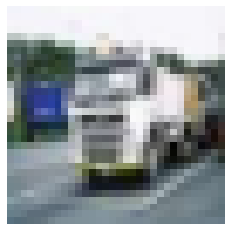

In [0]:
# Visualise the data
# The documentation writes: The first 1024 entries contain the red channel values, the next 1024 
# the green, and the final 1024 the blue. Hence, reshape to (NUM_CHANNELS, IMG_SIZE, IMG_SIZE).
X = trainX[1000].reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE)

plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(X.transpose(1,2,0))

## Without dropout
---

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

conv_1, pool_1, conv_2, pool_2, logits = cnn(x)

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Optimiser
# Momentum = 0.1
train_step_mom = tf.train.MomentumOptimizer(learning_rate, momentum=0.1).minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)


In [0]:
# Training

N = len(trainX)
idx = np.arange(N)

train_loss_all = []
test_acc_all = []

# With momentum = 0.1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    train_loss = []
    test_acc = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]
        
        # Mini batch learning
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step_mom.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

        if e % 100 == 0:
            print('iter', e, '--- train cost:', train_loss[e], ', test accuracy:', test_acc[e])


iter 0 --- train cost: 2.297487 , test accuracy: 0.137
iter 100 --- train cost: 1.5990658 , test accuracy: 0.4275
iter 200 --- train cost: 1.3863293 , test accuracy: 0.4875
iter 300 --- train cost: 1.2755164 , test accuracy: 0.518
iter 400 --- train cost: 1.1463282 , test accuracy: 0.5395
iter 500 --- train cost: 1.0186857 , test accuracy: 0.5605
iter 600 --- train cost: 0.93032616 , test accuracy: 0.57
iter 700 --- train cost: 0.8335793 , test accuracy: 0.5885
iter 800 --- train cost: 0.74071187 , test accuracy: 0.5865
iter 900 --- train cost: 0.64274913 , test accuracy: 0.597
iter 1000 --- train cost: 0.58585495 , test accuracy: 0.582
iter 1100 --- train cost: 0.48681554 , test accuracy: 0.59
iter 1200 --- train cost: 0.39530557 , test accuracy: 0.5875
iter 1300 --- train cost: 0.3221288 , test accuracy: 0.584
iter 1400 --- train cost: 0.2866044 , test accuracy: 0.584


In [0]:
train_loss_all.append(train_loss)
test_acc_all.append(test_acc)

train_loss_np = np.array(train_loss)
np.save('Qn3 train loss (Momentum no dropout).npy',train_loss_np)

test_acc_np = np.array(test_acc)
np.save('Qn3 test acc (Momentum no dropout).npy',test_acc_np)

## With dropout
---

In [0]:
def cnn_dropout(images):

    # channel first RGB images
    images = tf.reshape(images, [-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE])
    # convert to channel last
    images = tf.transpose(images, perm=[0,2,3,1])
    
    # Conv 1
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, FILTERS1], 
                                         stddev = 1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)), 
                     name='weights_1')
    b1 = tf.Variable(tf.zeros([FILTERS1]), name='biases_1')
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)

    # Pool 1
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_1')

    # Conv 2
    W2 = tf.Variable(tf.truncated_normal([5, 5, FILTERS1, FILTERS2], 
                                         stddev = 1.0 / np.sqrt(FILTERS1 * 5 * 5)), 
                     name='weights_2')
    b2 = tf.Variable(tf.zeros([FILTERS2]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)

    # Pool 2
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_2')
    # Flatten
    dim = pool_2.shape[1].value * pool_2.shape[2].value * pool_2.shape[3].value
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
	
    # Fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), 
                        name='weights_fc1')
    b_fc1 = tf.Variable(tf.zeros([300]), name='biases_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc1) + b_fc1)

    # Dropout
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Softmax
    W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), 
                        name='weights_fc2')
    b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_fc2')
    logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    return conv_1, pool_1, conv_2, pool_2, logits

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])
keep_prob = tf.placeholder(tf.float32)

conv_1, pool_1, conv_2, pool_2, logits = cnn_dropout(x)

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Optimiser
# Momentum = 0.1
train_step_mom = tf.train.MomentumOptimizer(learning_rate, momentum=0.1).minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

# Training
N = len(trainX)
idx = np.arange(N)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    train_loss = []
    test_acc = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]
        
        # Mini batch learning
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step_mom.run(feed_dict={x: trainX[start:end], y_: trainY[start:end], keep_prob: 0.5})

        train_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY, keep_prob: 0.5}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob: 1.0}))

        if e % 100 == 0:
            print('iter', e, '--- train cost:', train_loss[e], ', test accuracy:', test_acc[e])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
iter 0 --- train cost: 2.298243 , test accuracy: 0.102
iter 100 --- train cost: 1.707816 , test accuracy: 0.4105
iter 200 --- train cost: 1.5012121 , test accuracy: 0.497
iter 300 --- train cost: 1.392035 , test accuracy: 0.521
iter 400 --- train cost: 1.3100779 , test accuracy: 0.5385
iter 500 --- train cost: 1.2277205 , test accuracy: 0.5675
iter 600 --- train cost: 1.1444705 , test accuracy: 0.5795
iter 700 --- train cost: 1.0883195 , test accuracy: 0.59
iter 800 --- train cost: 1.0281943 , test accuracy: 0.6025
iter 900 --- train cost: 0.96525294 , test accuracy: 0.6065
iter 1000 --- train cost: 0.92347616 , test accuracy: 0.6055
iter 1100 --- train cost: 0.85821307 , test accuracy: 0.614
iter 1200 --- train cost: 0.804643 , test accuracy: 0.63
iter 1300 --- train cost: 0.73949057 , test accuracy: 0.6375
iter 1400 --- train cost: 0.71881026 , test accuracy: 0.6325


In [0]:
train_loss_all.append(train_loss)
test_acc_all.append(test_acc)

train_loss_np = np.array(train_loss)
np.save('Qn3 train loss (Momentum w dropout).npy',train_loss_np)

test_acc_np = np.array(test_acc)
np.save('Qn3 test acc (Momentum w dropout).npy',test_acc_np)

## Plot and comparison
---

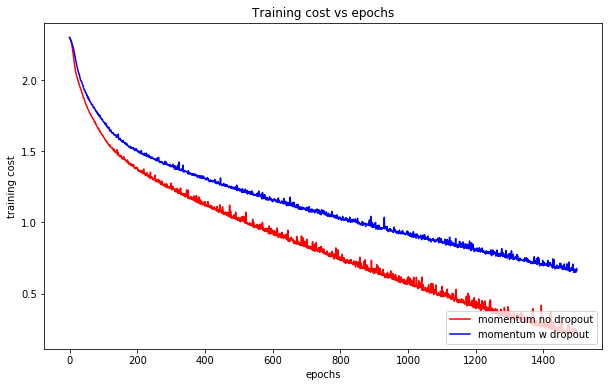

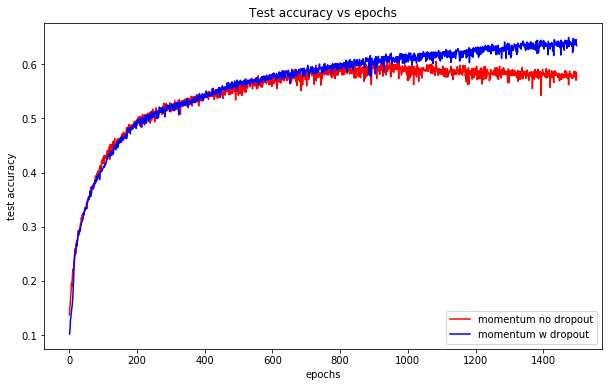

In [0]:
# Plot learning curve

plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs), train_loss_all[0], 'r', label = 'momentum no dropout')
plt.plot(np.arange(epochs), train_loss_all[1], 'b', label = 'momentum w dropout')
plt.title('Training cost vs epochs')
plt.xlabel('epochs')
plt.ylabel('training cost')
plt.legend(loc='lower right')

plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs), test_acc_all[0], 'r', label = 'momentum no dropout')
plt.plot(np.arange(epochs), test_acc_all[1], 'b', label = 'momentum w dropout')
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend(loc='lower right')
